<a href="https://colab.research.google.com/github/goodnessezichioum/DS-final-project/blob/main/economic-assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from functools import reduce
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
from scipy.stats import shapiro, normaltest
from statsmodels.tsa.stattools import adfuller
import joblib
import pickle
import json

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive"


 API_NGA_DS2_en_csv_v2_130484   IMDB_overview_genres.csv
'Colab Notebooks'	        Multimodal_IMDB_dataset
 housing.csv		        spark-3.3.0-bin-hadoop3.tgz
 Images


In [5]:
csv_path = "/content/drive/MyDrive/API_NGA_DS2_en_csv_v2_130484/API_NGA_DS2_en_csv_v2_130484.csv"
df_raw = pd.read_csv(csv_path, header=2)

df_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Nigeria,NGA,"Industry (including construction), value added...",NV.IND.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.323377e+04,1.364962e+04,1.238158e+04,1.129614e+04,1.065833e+04,1.093960e+04,1.082549e+04,1.058846e+04,9.866392e+03,1.025967e+04,1.047256e+04,1.028540e+04,1.112731e+04,1.094869e+04,1.119730e+04,1.103451e+04,1.083389e+04,1.058920e+04,1.080453e+04,1.126627e+04,1.203161e+04,1.117395e+04,1.034883e+04,1.040863e+04,9.682647e+03,8.442150e+03,8.180626e+03,7.897489e+03,7.643102e+03,6.466857e+03,5.858894e+03,4.845714e+03,4.547890e+03,NaN,NaN
1,Nigeria,NGA,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.364373e+12,2.425961e+12,2.409082e+12,2.303505e+12,2.731062e+12,2.986835e+12,2.891672e+12,3.174568e+12,3.325947e+12,3.464716e+12,3.590837e+12,3.674793e+12,3.743666e+12,3.839675e+12,3.977382e+12,4.133548e+12,4.305680e+12,4.475241e+12,4.703644e+12,4.840971e+12,5.024542e+12,7.817084e+12,8.364832e+12,8.888573e+12,9.516992e+12,1.022247e+13,1.095847e+13,1.164537e+13,1.233033e+13,1.304889e+13,1.342938e+13,1.432971e+13,1.475052e+13,1.538039e+13,1.595222e+13,1.660734e+13,1.717950e+13,1.754415e+13,1.795858e+13,1.834818e+13,1.873841e+13,1.909107e+13,1.930649e+13,1.953588e+13,NaN
2,Nigeria,NGA,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.013244e+10,1.927770e+10,1.455524e+10,1.345378e+10,1.344212e+10,9.876248e+09,1.082604e+10,1.160367e+10,9.361914e+09,1.164810e+10,1.243235e+10,1.057883e+10,1.332442e+10,2.023968e+10,3.591553e+10,4.865976e+10,5.506645e+10,6.095640e+10,1.539457e+10,1.477311e+10,1.800354e+10,3.513681e+10,3.543011e+10,3.696935e+10,4.583119e+10,5.898182e+10,6.862630e+10,8.581876e+10,7.891148e+10,8.768760e+10,9.215547e+10,1.014239e+11,1.079692e+11,1.147808e+11,1.017207e+11,8.490797e+10,7.833010e+10,8.942464e+10,1.039492e+11,1.043471e+11,1.029658e+11,1.131058e+11,8.268385e+10,3.821519e+10,NaN
3,Nigeria,NGA,External balance on goods and services (consta...,NE.RSB.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nigeria,NGA,Imports of goods and services (constant LCU),NE.IMP.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_raw = df_raw[df_raw["Country Code"] == "NGA"].reset_index(drop=True)

In [7]:
year_cols = [col for col in df_raw.columns if re.match(r"^\d{4}$", str(col))]

# Keeping only descriptive columns + year columns to simplify dataset
df = df_raw[["Indicator Name", "Indicator Code"] + year_cols].copy()

print(df.shape)
df.head()



(1516, 67)


,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Industry (including construction), value added...",NV.IND.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.323377e+04,1.364962e+04,1.238158e+04,1.129614e+04,1.065833e+04,1.093960e+04,1.082549e+04,1.058846e+04,9.866392e+03,1.025967e+04,1.047256e+04,1.028540e+04,1.112731e+04,1.094869e+04,1.119730e+04,1.103451e+04,1.083389e+04,1.058920e+04,1.080453e+04,1.126627e+04,1.203161e+04,1.117395e+04,1.034883e+04,1.040863e+04,9.682647e+03,8.442150e+03,8.180626e+03,7.897489e+03,7.643102e+03,6.466857e+03,5.858894e+03,4.845714e+03,4.547890e+03,NaN
1,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.364373e+12,2.425961e+12,2.409082e+12,2.303505e+12,2.731062e+12,2.986835e+12,2.891672e+12,3.174568e+12,3.325947e+12,3.464716e+12,3.590837e+12,3.674793e+12,3.743666e+12,3.839675e+12,3.977382e+12,4.133548e+12,4.305680e+12,4.475241e+12,4.703644e+12,4.840971e+12,5.024542e+12,7.817084e+12,8.364832e+12,8.888573e+12,9.516992e+12,1.022247e+13,1.095847e+13,1.164537e+13,1.233033e+13,1.304889e+13,1.342938e+13,1.432971e+13,1.475052e+13,1.538039e+13,1.595222e+13,1.660734e+13,1.717950e+13,1.754415e+13,1.795858e+13,1.834818e+13,1.873841e+13,1.909107e+13,1.930649e+13,1.953588e+13
2,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.013244e+10,1.927770e+10,1.455524e+10,1.345378e+10,1.344212e+10,9.876248e+09,1.082604e+10,1.160367e+10,9.361914e+09,1.164810e+10,1.243235e+10,1.057883e+10,1.332442e+10,2.023968e+10,3.591553e+10,4.865976e+10,5.506645e+10,6.095640e+10,1.539457e+10,1.477311e+10,1.800354e+10,3.513681e+10,3.543011e+10,3.696935e+10,4.583119e+10,5.898182e+10,6.862630e+10,8.581876e+10,7.891148e+10,8.768760e+10,9.215547e+10,1.014239e+11,1.079692e+11,1.147808e+11,1.017207e+11,8.490797e+10,7.833010e+10,8.942464e+10,1.039492e+11,1.043471e+11,1.029658e+11,1.131058e+11,8.268385e+10,3.821519e+10
3,External balance on goods and services (consta...,NE.RSB.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Imports of goods and services (constant LCU),NE.IMP.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#function for longest run
def longest_run_nonmissing(row):
    longest = current = 0
    for col in year_cols:
        if pd.notna(row[col]):
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    return longest

df["coverage_%"] = df[year_cols].notna().mean(axis=1) * 100
df["first_year"] = df[year_cols].apply(lambda r: r.first_valid_index(), axis=1)
df["last_year"]  = df[year_cols].apply(lambda r: r.last_valid_index(), axis=1)
df["longest_run"] = df.apply(longest_run_nonmissing, axis=1)


capital_keywords = [
    "capital formation", "gross fixed", "investment", "savings",
    "government expenditure", "capital stock"
]

external_keywords = [
    "export", "import", "trade", "balance", "fdi", "foreign direct", "current account"
]

# filtering each category
capital_df = (
    df[df["Indicator Name"].str.contains("|".join(capital_keywords), case=False, na=False)]
    .sort_values(by="coverage_%", ascending=False)
)

external_df = (
    df[df["Indicator Name"].str.contains("|".join(external_keywords), case=False, na=False)]
    .sort_values(by="coverage_%", ascending=False)
)

print(" Top 5 Capital Indicators ")
print(capital_df[["Indicator Name", "Indicator Code", "coverage_%", "longest_run"]].head(5))

print("\n Top 5 External Indicators ")
print(external_df[["Indicator Name", "Indicator Code", "coverage_%", "longest_run"]].head(5))


 Top 5 Capital Indicators 
                                         Indicator Name        Indicator Code  \
1204  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
1145  Foreign direct investment, net inflows (BoP, c...     BX.KLT.DINV.CD.WD   
1453  Adjusted savings: education expenditure (% of ...     NY.ADJ.AEDU.GN.ZS   
65    Adjusted savings: consumption of fixed capital...     NY.ADJ.DKAP.GN.ZS   
1413  Adjusted savings: natural resources depletion ...     NY.ADJ.DRES.GN.ZS   

      coverage_%  longest_run  
1204   84.615385           55  
1145   84.615385           55  
1453   80.000000           52  
65     80.000000           52  
1413   80.000000           52  

 Top 5 External Indicators 
                                        Indicator Name     Indicator Code  \
577                  Merchandise imports (current US$)  TM.VAL.MRCH.CD.WT   
638                  Merchandise exports (current US$)  TX.VAL.MRCH.CD.WT   
453                       Merchand

In [11]:
def extract_indicator(code, name):
    year_cols = [str(y) for y in range(1960, 2025)]
    row = df[df["Indicator Code"] == code]
    ts = row[year_cols].T
    ts.columns = [name]
    ts.index.name = "Year"
    ts.reset_index(inplace=True)
    ts["Year"] = ts["Year"].astype(int)
    ts[name] = pd.to_numeric(ts[name], errors="coerce")
    return ts

In [13]:
#Extracting indicators

indicators = {
    # TARGET VARIABLE -  GDP Growth Rate
    "NY.GDP.MKTP.KD.ZG": "GDP_Growth",  # GDP growth (annual %)

    # Feature variables (selected based on data availability and economic relevance)
    "NY.GDP.DEFL.KD.ZG": "Inflation",          # Inflation rate (%)
    "SP.POP.GROW": "Population_Growth",         # Population growth rate (%)
    "BX.KLT.DINV.WD.GD.ZS": "FDI_inflows",     # Foreign Direct Investment (% of GDP)
     "TX.VAL.MRCH.CD.WT": "Exports",           # Goods exports
    "SL.UEM.TOTL.ZS": "Unemployment",          # Unemployment rate (%)
}


In [14]:
# Merge all indicators into a single DataFrame
print("\nMerging indicators...")
df_merged = dataframes["GDP_Growth"].copy()
for name, ts in dataframes.items():
    if name != "GDP_Growth":
        df_merged = df_merged.merge(ts, on="Year", how="outer")

df_merged = df_merged.sort_values("Year").reset_index(drop=True)
print(f"Merged dataset: {df_merged.shape[0]} years, {df_merged.shape[1]} columns")


Merging indicators...
Merged dataset: 65 years, 7 columns


In [17]:
df_merged = dataframes["GDP_Growth"].copy()
for name, ts in dataframes.items():
    if name != "GDP_Growth":
        df_merged = df_merged.merge(ts, on="Year", how="outer")

df_merged = df_merged.sort_values("Year").reset_index(drop=True)
print(f"Merged dataset: {df_merged.shape[0]} years, {df_merged.shape[1]} columns")

df_merged.isna().sum()


Merged dataset: 65 years, 7 columns


,0
Year,0
GDP_Growth,1
Inflation,1
Population_Growth,1
FDI_inflows,10
Exports,0
Unemployment,31


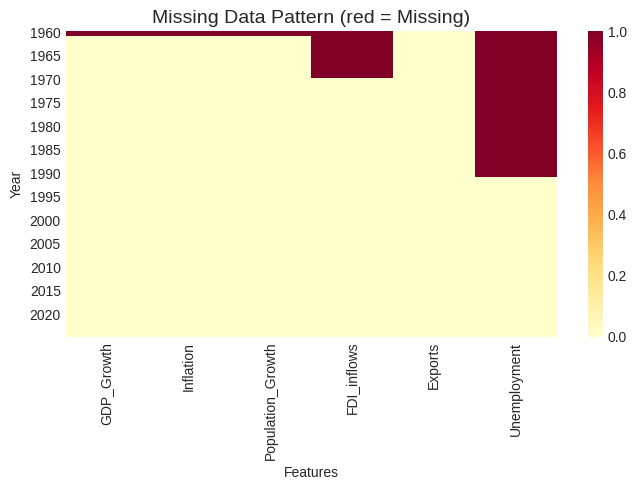

Saved: 01_missing_data_pattern.png


In [19]:
fig, ax = plt.subplots(figsize=(7, 5))
missing_matrix = df_merged.set_index('Year').isna().astype(int)
sns.heatmap(missing_matrix, cbar=True, yticklabels=5, cmap='YlOrRd', ax=ax)
ax.set_title('Missing Data Pattern (red = Missing)', fontsize=14)
ax.set_xlabel('Features')
ax.set_ylabel('Year')
plt.tight_layout()
plt.savefig('01_missing_data_pattern.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 01_missing_data_pattern.png")


In [25]:
#Dropping na values over 30 years

df_clean = df_merged.dropna()
df_clean.isna().sum()

,0
Year,0
GDP_Growth,0
Inflation,0
Population_Growth,0
FDI_inflows,0
Exports,0
Unemployment,0


In [26]:
df_clean.head()

,Year,GDP_Growth,Inflation,Population_Growth,FDI_inflows,Exports,Unemployment
31,1991,0.358353,18.863907,2.641103,1.196726,1.226400e+10,3.851
32,1992,4.631193,46.752355,2.625288,1.722383,1.188600e+10,3.810
33,1993,-2.035119,41.639059,2.650148,2.371903,9.908000e+09,4.038
34,1994,-1.814924,43.296464,2.641357,2.436852,9.415000e+09,4.078
35,1995,-0.072665,75.401653,2.636629,0.238322,1.234200e+10,4.163


In [33]:
print("\n6.1 STATIONARITY TEST (Augmented Dickey-Fuller)")
print("-" * 50)

def adf_test(series, name):
    """
    Perform Augmented Dickey-Fuller test for stationarity.

    A stationary series has constant mean and variance over time.
    Most time series methods assume stationarity.

    H0: Series has unit root (non-stationary)
    If p-value < 0.05: Reject H0, series IS stationary
    """
    result = adfuller(series.dropna())
    adf_stat = result[0]
    p_value = result[1]
    is_stationary = p_value < 0.05

    print(f"\n{name}:")
    print(f"  ADF Statistic: {adf_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Stationary: {'YES ✓' if is_stationary else 'NO ✗'}")
    return is_stationary, p_value

stat_growth, p_growth = adf_test(df_clean['GDP_Growth'], "GDP Growth Rate")

if stat_growth:
    print("\n✓ GDP Growth is stationary ")
else:
    print("\n⚠ GDP Growth may not be stationary")
    # suitable for time series modeling


6.1 STATIONARITY TEST (Augmented Dickey-Fuller)
--------------------------------------------------

GDP Growth Rate:
  ADF Statistic: -3.0099
  p-value: 0.0340
  Stationary: YES ✓

✓ GDP Growth is stationary 



6.2 Creating GDP Growth time series plot...


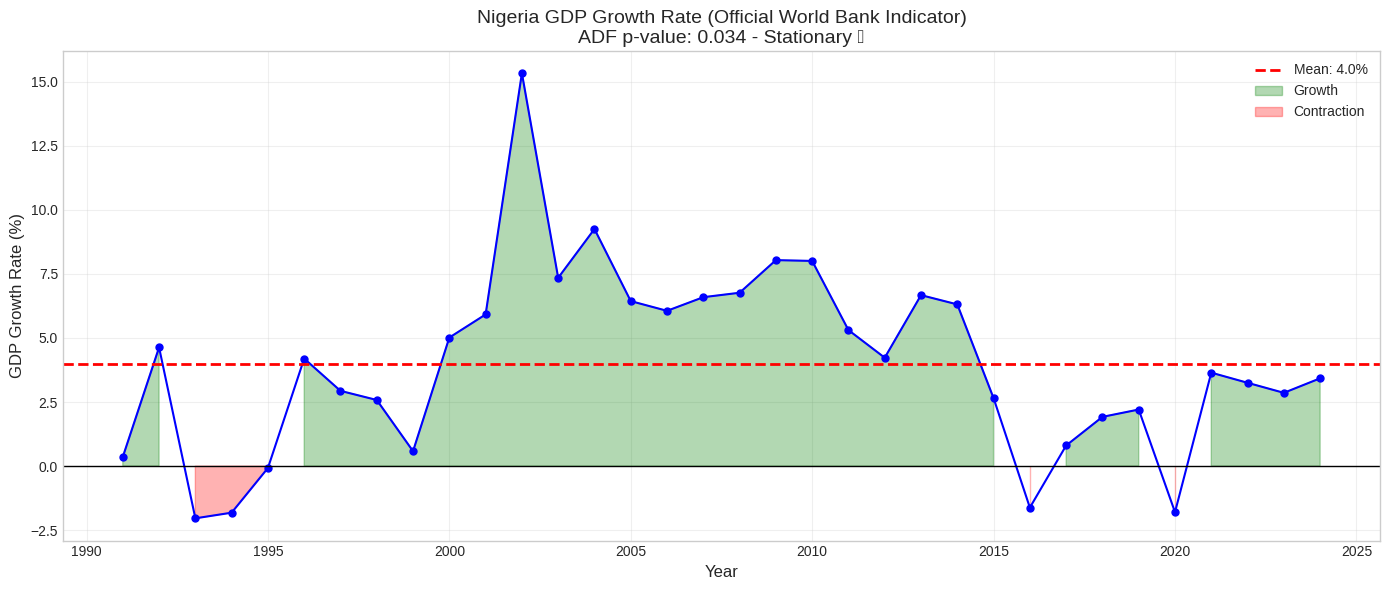

In [37]:
print("\n6.2 Creating GDP Growth time series plot...")

fig, ax = plt.subplots(figsize=(14, 6))

# Plot GDP Growth
ax.plot(df_clean['Year'], df_clean['GDP_Growth'], 'b-o', markersize=5, linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=df_clean['GDP_Growth'].mean(), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {df_clean["GDP_Growth"].mean():.1f}%')

# Color regions
ax.fill_between(df_clean['Year'], 0, df_clean['GDP_Growth'],
                where=(df_clean['GDP_Growth'] >= 0), alpha=0.3, color='green', label='Growth')
ax.fill_between(df_clean['Year'], 0, df_clean['GDP_Growth'],
                where=(df_clean['GDP_Growth'] < 0), alpha=0.3, color='red', label='Contraction')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP Growth Rate (%)', fontsize=12)
ax.set_title(f'Nigeria GDP Growth Rate (Official World Bank Indicator)\nADF p-value: {p_growth:.3f} - {"Stationary ✓" if stat_growth else "Non-stationary"}', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('01_gdp_growth_time_series.png', dpi=150, bbox_inches='tight')
plt.close()
plt.show()


6.3 Creating GDP Growth distribution plot...


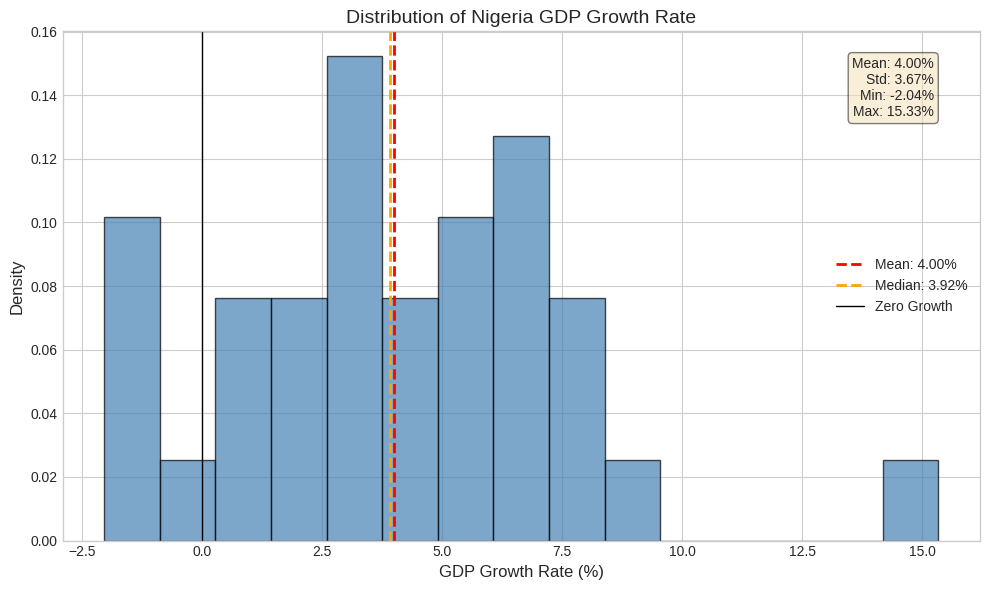

  Saved: 02_gdp_growth_distribution.png

GDP Growth Summary Statistics:
  Mean:   4.00%
  Median: 3.92%
  Std:    3.67%
  Min:    -2.04%
  Max:    15.33%


In [39]:
print("\n6.3 Creating GDP Growth distribution plot...")

fig, ax = plt.subplots(figsize=(10, 6))

mean_growth = df_clean['GDP_Growth'].mean()
median_growth = df_clean['GDP_Growth'].median()
std_growth = df_clean['GDP_Growth'].std()

ax.hist(df_clean['GDP_Growth'], bins=15, density=True, alpha=0.7,
        color='steelblue', edgecolor='black')

ax.axvline(mean_growth, color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mean_growth:.2f}%')
ax.axvline(median_growth, color='orange', linestyle='--', linewidth=2,
           label=f'Median: {median_growth:.2f}%')
ax.axvline(0, color='black', linestyle='-', linewidth=1, label='Zero Growth')

ax.set_xlabel('GDP Growth Rate (%)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Nigeria GDP Growth Rate', fontsize=14)
ax.legend()

# Add stats text box
stats_text = f'Mean: {mean_growth:.2f}%\nStd: {std_growth:.2f}%\nMin: {df_clean["GDP_Growth"].min():.2f}%\nMax: {df_clean["GDP_Growth"].max():.2f}%'
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()
plt.savefig('02_gdp_growth_distribution.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: 02_gdp_growth_distribution.png")

print(f"\nGDP Growth Summary Statistics:")
print(f"  Mean:   {mean_growth:.2f}%")
print(f"  Median: {median_growth:.2f}%")
print(f"  Std:    {std_growth:.2f}%")
print(f"  Min:    {df_clean['GDP_Growth'].min():.2f}%")
print(f"  Max:    {df_clean['GDP_Growth'].max():.2f}%")



6.4 Creating correlation matrix...


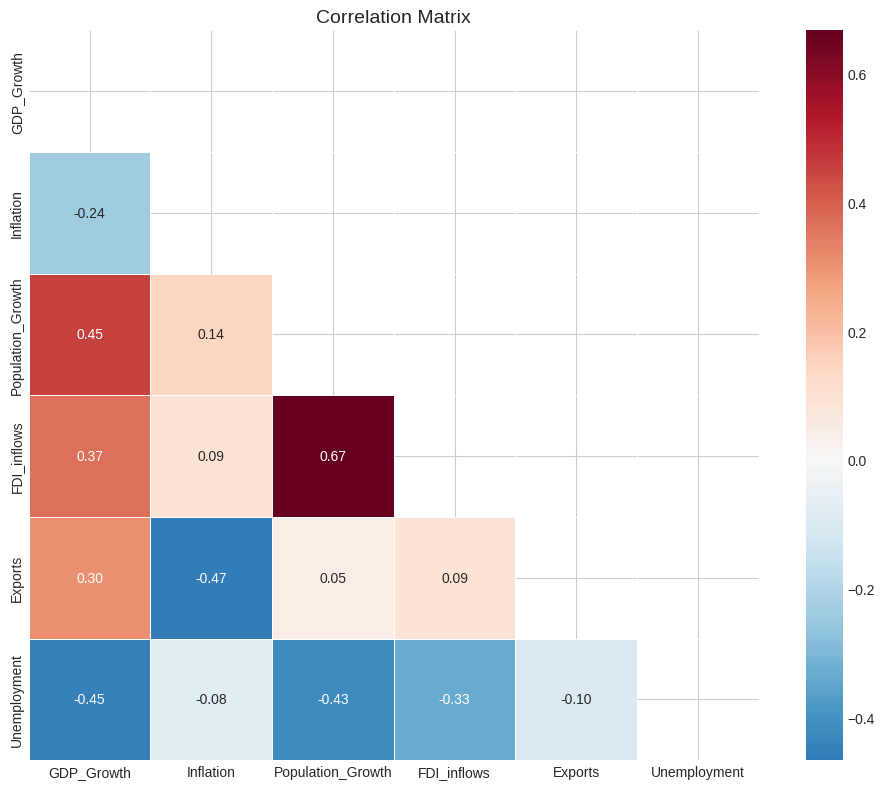

  Saved: 03_correlation_matrix.png

Correlations with GDP Growth:
  Population_Growth   : +0.451 (Moderate)
  Unemployment        : -0.450 (Moderate)
  FDI_inflows         : +0.370 (Moderate)
  Exports             : +0.300 (Weak)
  Inflation           : -0.239 (Weak)


In [41]:
print("\n6.4 Creating correlation matrix...")

# Get numeric columns for correlation
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Year']

corr_matrix = df_clean[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            mask=mask, square=True, linewidths=0.5, fmt='.2f',
            annot_kws={'size': 10}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig('03_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: 03_correlation_matrix.png")

# Print correlations with GDP Growth
print("\nCorrelations with GDP Growth:")
gdp_corr = corr_matrix['GDP_Growth'].drop('GDP_Growth').sort_values(key=abs, ascending=False)
for feat, corr in gdp_corr.items():
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    print(f"  {feat:20s}: {corr:+.3f} ({strength})")



6.5 Creating time series plots for all features...


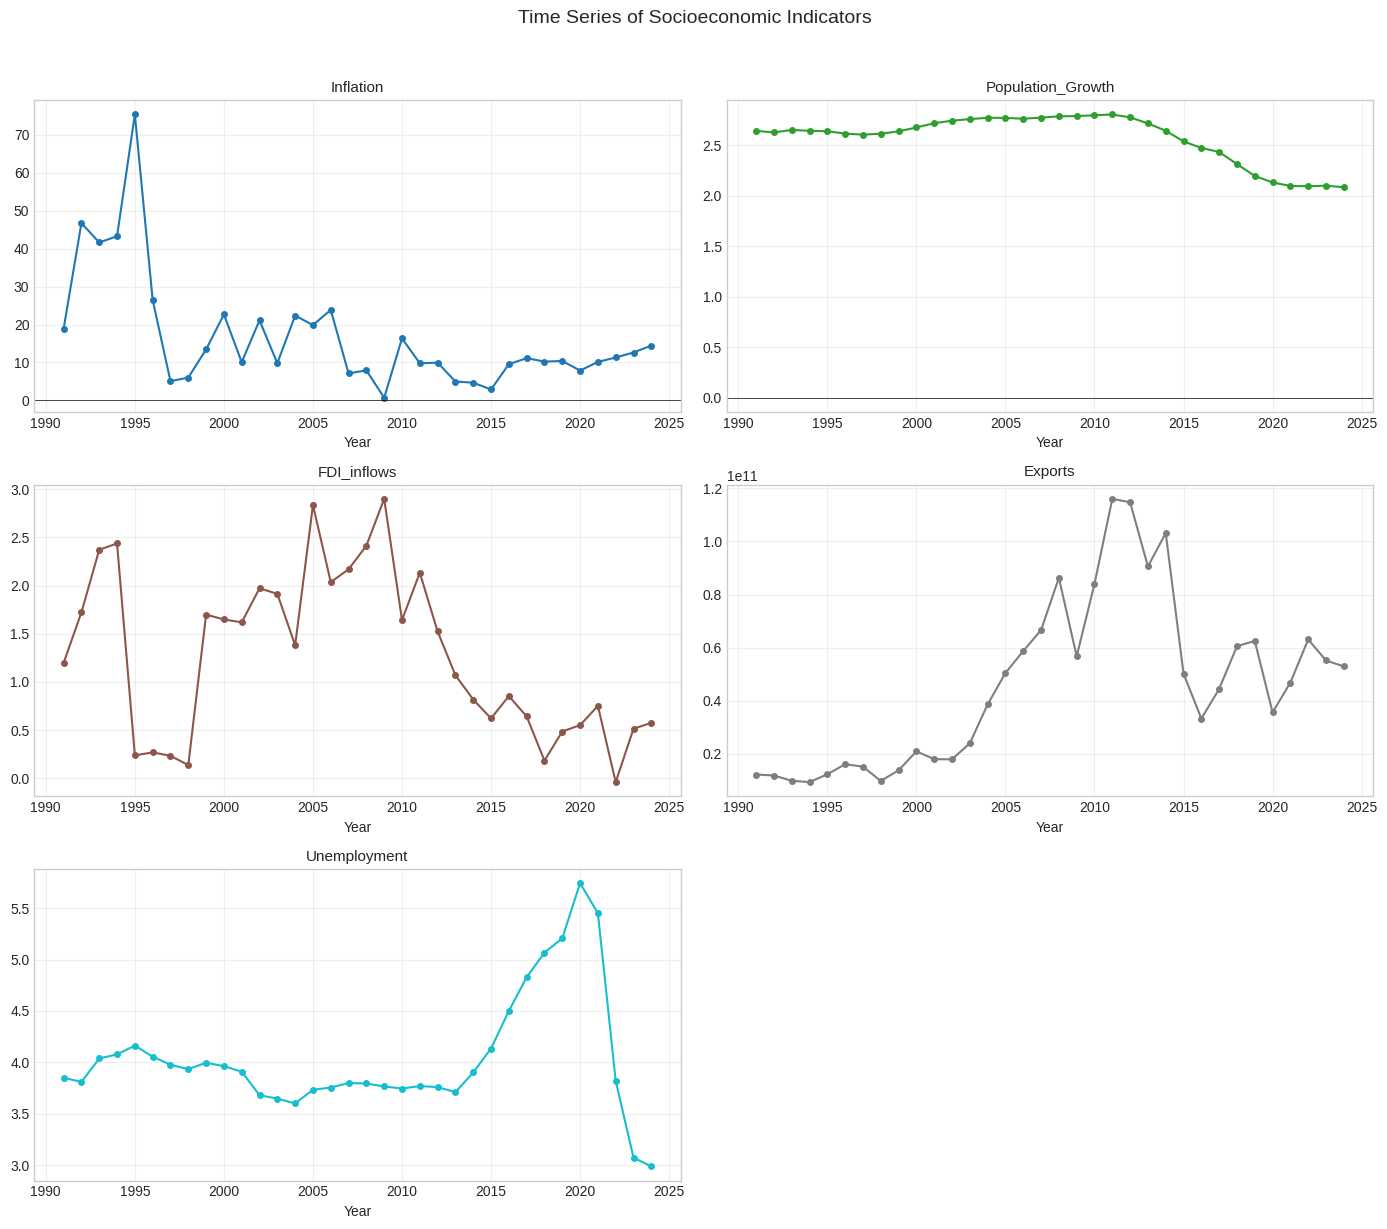

  Saved: 04_feature_time_series.png


In [43]:
print("\n6.5 Creating time series plots for all features...")

feature_cols_plot = [c for c in numeric_cols if c != 'GDP_Growth']
n_features = len(feature_cols_plot)
n_rows = (n_features + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, n_features))

for i, col in enumerate(feature_cols_plot):
    ax = axes[i]
    ax.plot(df_clean['Year'], df_clean[col], marker='o', markersize=4,
            linewidth=1.5, color=colors[i])
    ax.set_title(f'{col}', fontsize=11)
    ax.set_xlabel('Year')
    ax.grid(True, alpha=0.3)
    if 'Growth' in col or col == 'Inflation' or col == 'Current_Account':
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Time Series of Socioeconomic Indicators', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('04_feature_time_series.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: 04_feature_time_series.png")

In [44]:
# Version 1: Base features only
df_base = final_df.copy()
base_feature_cols = ['Inflation', 'Population_Growth', 'FDI_inflows', 'Goods_exports']
print(f"\nBase features: {base_feature_cols}")

# Version 2: with lag features
df_lag = final_df.copy()

# Create lag features
for lag in [1, 2, 3]:
    df_lag[f'GDP_lag_{lag}'] = df_lag['GDP_per_capita'].shift(lag)

# Create rolling statistics
df_lag['GDP_rolling_mean_3'] = df_lag['GDP_per_capita'].rolling(window=3).mean()

# Drop rows with NaN from lag creation
df_lag = df_lag.dropna().reset_index(drop=True)

lag_feature_cols = base_feature_cols + ['GDP_lag_1', 'GDP_lag_2', 'GDP_lag_3', 'GDP_rolling_mean_3']
print(f"Lag features: {lag_feature_cols}")

print(f"\nDataset sizes:")
print(f"  Base features dataset: {len(df_base)} samples")
print(f"  Lag features dataset: {len(df_lag)} samples")


Base features: ['Inflation', 'Population_Growth', 'FDI_inflows', 'Goods_exports']


KeyError: 'GDP_per_capita'

In [ ]:
HOLDOUT_START_YEAR = 2022

# Split for base features
train_base = df_base[df_base['Year'] < HOLDOUT_START_YEAR].copy()
holdout_base = df_base[df_base['Year'] >= HOLDOUT_START_YEAR].copy()

X_train_base = train_base[base_feature_cols]
y_train_base = train_base['GDP_per_capita']
X_holdout_base = holdout_base[base_feature_cols]
y_holdout_base = holdout_base['GDP_per_capita']

# Split for lag features
train_lag = df_lag[df_lag['Year'] < HOLDOUT_START_YEAR].copy()
holdout_lag = df_lag[df_lag['Year'] >= HOLDOUT_START_YEAR].copy()

X_train_lag = train_lag[lag_feature_cols]
y_train_lag = train_lag['GDP_per_capita']
X_holdout_lag = holdout_lag[lag_feature_cols]
y_holdout_lag = holdout_lag['GDP_per_capita']

print("Data Split Summary:")
print(f"\n  BASE FEATURES (no lags):")
print(f"    Training: {len(X_train_base)} samples ({train_base['Year'].min()}-{train_base['Year'].max()})")
print(f"    Holdout:  {len(X_holdout_base)} samples ({holdout_base['Year'].min()}-{holdout_base['Year'].max()})")

print(f"\n  LAG FEATURES:")
print(f"    Training: {len(X_train_lag)} samples ({train_lag['Year'].min()}-{train_lag['Year'].max()})")
print(f"    Holdout:  {len(X_holdout_lag)} samples ({holdout_lag['Year'].min()}-{holdout_lag['Year'].max()})")

# Visualize split
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_base['Year'], y_train_base, 'bo-', label='Training Data', markersize=6)
ax.plot(holdout_base['Year'], y_holdout_base, 'ro-', label='Holdout Data', markersize=8)
ax.axvline(x=HOLDOUT_START_YEAR - 0.5, color='gray', linestyle='--', linewidth=2, label='Split Point')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP per Capita (constant 2015 US$)', fontsize=12)
ax.set_title('Train/Holdout Split', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('05_data_split.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 05_data_split.png")

In [ ]:
# Scaler for base features
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_holdout_base_scaled = scaler_base.transform(X_holdout_base)

# Scaler for lag features
scaler_lag = StandardScaler()
X_train_lag_scaled = scaler_lag.fit_transform(X_train_lag)
X_holdout_lag_scaled = scaler_lag.transform(X_holdout_lag)

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"Using TimeSeriesSplit with {n_splits} folds")
print("\nFolds for BASE features dataset:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_base_scaled)):
    train_years = train_base.iloc[train_idx]['Year']
    val_years = train_base.iloc[val_idx]['Year']
    print(f"  Fold {i+1}: Train {train_years.min()}-{train_years.max()} ({len(train_idx)}) | "
          f"Val {val_years.min()}-{val_years.max()} ({len(val_idx)})")

rmse_scorer = make_scorer(lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred)))


In [ ]:
base_results = {}

# Baseline
print("\n12.1 Baseline (Predict Mean)")
baseline_cv_scores = []
for train_idx, val_idx in tscv.split(X_train_base_scaled):
    y_val = y_train_base.iloc[val_idx]
    pred = np.full(len(y_val), y_train_base.iloc[train_idx].mean())
    baseline_cv_scores.append(np.sqrt(mean_squared_error(y_val, pred)))
base_results['Baseline'] = {'cv_rmse': np.mean(baseline_cv_scores), 'cv_std': np.std(baseline_cv_scores)}
print(f"  CV RMSE: {np.mean(baseline_cv_scores):.2f} ± {np.std(baseline_cv_scores):.2f}")

# Linear Regression
print("\n12.2 Linear Regression")
lr_base = LinearRegression()
lr_cv = cross_val_score(lr_base, X_train_base_scaled, y_train_base, cv=tscv, scoring=rmse_scorer)
lr_base.fit(X_train_base_scaled, y_train_base)
base_results['Linear Regression'] = {'cv_rmse': -np.mean(lr_cv), 'cv_std': np.std(lr_cv), 'model': lr_base}
print(f"  CV RMSE: {-np.mean(lr_cv):.2f} ± {np.std(lr_cv):.2f}")

# Ridge Regression
print("\n12.3 Ridge Regression")
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_base = Ridge()
ridge_cv = GridSearchCV(ridge_base, ridge_params, cv=tscv, scoring=rmse_scorer)
ridge_cv.fit(X_train_base_scaled, y_train_base)
ridge_best_base = ridge_cv.best_estimator_
base_results['Ridge'] = {
    'cv_rmse': -ridge_cv.best_score_,
    'cv_std': ridge_cv.cv_results_['std_test_score'][ridge_cv.best_index_],
    'model': ridge_best_base,
    'best_alpha': ridge_cv.best_params_['alpha']
}
print(f"  Best alpha: {ridge_cv.best_params_['alpha']}")
print(f"  CV RMSE: {-ridge_cv.best_score_:.2f}")

# Random Forest
print("\n12.4 Random Forest")
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5]}
rf_base = RandomForestRegressor(random_state=RANDOM_STATE)
rf_cv = RandomizedSearchCV(rf_base, rf_params, n_iter=15, cv=tscv, scoring=rmse_scorer, random_state=RANDOM_STATE)
rf_cv.fit(X_train_base_scaled, y_train_base)
rf_best_base = rf_cv.best_estimator_
base_results['Random Forest'] = {
    'cv_rmse': -rf_cv.best_score_,
    'cv_std': rf_cv.cv_results_['std_test_score'][rf_cv.best_index_],
    'model': rf_best_base,
    'best_params': rf_cv.best_params_
}
print(f"  Best params: {rf_cv.best_params_}")
print(f"  CV RMSE: {-rf_cv.best_score_:.2f}")

# XGBoost
print("\n12.5 XGBoost")
xgb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 4, 5], 'subsample': [0.7, 0.8, 0.9]}
xgb_base = XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
xgb_cv = RandomizedSearchCV(xgb_base, xgb_params, n_iter=15, cv=tscv, scoring=rmse_scorer, random_state=RANDOM_STATE)
xgb_cv.fit(X_train_base_scaled, y_train_base)
xgb_best_base = xgb_cv.best_estimator_
base_results['XGBoost'] = {
    'cv_rmse': -xgb_cv.best_score_,
    'cv_std': xgb_cv.cv_results_['std_test_score'][xgb_cv.best_index_],
    'model': xgb_best_base,
    'best_params': xgb_cv.best_params_
}
print(f"  Best params: {xgb_cv.best_params_}")
print(f"  CV RMSE: {-xgb_cv.best_score_:.2f}")

In [ ]:
lag_results = {}

# Baseline
print("\n13.1 Baseline (Predict Mean)")
baseline_cv_lag = []
for train_idx, val_idx in tscv.split(X_train_lag_scaled):
    y_val = y_train_lag.iloc[val_idx]
    pred = np.full(len(y_val), y_train_lag.iloc[train_idx].mean())
    baseline_cv_lag.append(np.sqrt(mean_squared_error(y_val, pred)))
lag_results['Baseline'] = {'cv_rmse': np.mean(baseline_cv_lag), 'cv_std': np.std(baseline_cv_lag)}
print(f"  CV RMSE: {np.mean(baseline_cv_lag):.2f} ± {np.std(baseline_cv_lag):.2f}")

# Linear Regression
print("\n13.2 Linear Regression")
lr_lag = LinearRegression()
lr_cv_lag = cross_val_score(lr_lag, X_train_lag_scaled, y_train_lag, cv=tscv, scoring=rmse_scorer)
lr_lag.fit(X_train_lag_scaled, y_train_lag)
lag_results['Linear Regression'] = {'cv_rmse': -np.mean(lr_cv_lag), 'cv_std': np.std(lr_cv_lag), 'model': lr_lag}
print(f"  CV RMSE: {-np.mean(lr_cv_lag):.2f} ± {np.std(lr_cv_lag):.2f}")

# Ridge Regression
print("\n13.3 Ridge Regression")
ridge_lag = Ridge()
ridge_cv_lag = GridSearchCV(ridge_lag, ridge_params, cv=tscv, scoring=rmse_scorer)
ridge_cv_lag.fit(X_train_lag_scaled, y_train_lag)
ridge_best_lag = ridge_cv_lag.best_estimator_
lag_results['Ridge'] = {
    'cv_rmse': -ridge_cv_lag.best_score_,
    'cv_std': ridge_cv_lag.cv_results_['std_test_score'][ridge_cv_lag.best_index_],
    'model': ridge_best_lag
}
print(f"  CV RMSE: {-ridge_cv_lag.best_score_:.2f}")

# Random Forest
print("\n13.4 Random Forest")
rf_lag = RandomForestRegressor(random_state=RANDOM_STATE)
rf_cv_lag = RandomizedSearchCV(rf_lag, rf_params, n_iter=15, cv=tscv, scoring=rmse_scorer, random_state=RANDOM_STATE)
rf_cv_lag.fit(X_train_lag_scaled, y_train_lag)
rf_best_lag = rf_cv_lag.best_estimator_
lag_results['Random Forest'] = {
    'cv_rmse': -rf_cv_lag.best_score_,
    'cv_std': rf_cv_lag.cv_results_['std_test_score'][rf_cv_lag.best_index_],
    'model': rf_best_lag,
    'feature_importance': dict(zip(lag_feature_cols, rf_best_lag.feature_importances_))
}
print(f"  CV RMSE: {-rf_cv_lag.best_score_:.2f}")

# XGBoost
print("\n13.5 XGBoost")
xgb_lag = XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
xgb_cv_lag = RandomizedSearchCV(xgb_lag, xgb_params, n_iter=15, cv=tscv, scoring=rmse_scorer, random_state=RANDOM_STATE)
xgb_cv_lag.fit(X_train_lag_scaled, y_train_lag)
xgb_best_lag = xgb_cv_lag.best_estimator_
lag_results['XGBoost'] = {
    'cv_rmse': -xgb_cv_lag.best_score_,
    'cv_std': xgb_cv_lag.cv_results_['std_test_score'][xgb_cv_lag.best_index_],
    'model': xgb_best_lag,
    'feature_importance': dict(zip(lag_feature_cols, xgb_best_lag.feature_importances_))
}
print(f"  CV RMSE: {-xgb_cv_lag.best_score_:.2f}")

In [ ]:
# Create comparison DataFrames
base_comparison = pd.DataFrame([
    {'Model': k, 'CV RMSE': v['cv_rmse'], 'CV Std': v.get('cv_std', 0)}
    for k, v in base_results.items()
]).sort_values('CV RMSE')

lag_comparison = pd.DataFrame([
    {'Model': k, 'CV RMSE': v['cv_rmse'], 'CV Std': v.get('cv_std', 0)}
    for k, v in lag_results.items()
]).sort_values('CV RMSE')

print("\nBASE FEATURES (No Lag) - Cross-Validation Results:")
print("-" * 50)
for _, row in base_comparison.iterrows():
    print(f"  {row['Model']:<20} RMSE: {row['CV RMSE']:>8.2f} ± {row['CV Std']:.2f}")

print("\nLAG FEATURES - Cross-Validation Results:")
print("-" * 50)
for _, row in lag_comparison.iterrows():
    print(f"  {row['Model']:<20} RMSE: {row['CV RMSE']:>8.2f} ± {row['CV Std']:.2f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Base features
ax1 = axes[0]
colors1 = ['green' if m == base_comparison.iloc[0]['Model'] else 'steelblue' for m in base_comparison['Model']]
bars1 = ax1.barh(base_comparison['Model'], base_comparison['CV RMSE'],
                  xerr=base_comparison['CV Std'], capsize=5, color=colors1, alpha=0.7)
ax1.set_xlabel('RMSE')
ax1.set_title('BASE FEATURES (Economic Indicators Only)', fontsize=12)
ax1.set_xlim(0, max(base_comparison['CV RMSE']) * 1.3)

# Lag features
ax2 = axes[1]
colors2 = ['green' if m == lag_comparison.iloc[0]['Model'] else 'steelblue' for m in lag_comparison['Model']]
bars2 = ax2.barh(lag_comparison['Model'], lag_comparison['CV RMSE'],
                  xerr=lag_comparison['CV Std'], capsize=5, color=colors2, alpha=0.7)
ax2.set_xlabel('RMSE')
ax2.set_title('LAG FEATURES (With Previous GDP)', fontsize=12)
ax2.set_xlim(0, max(lag_comparison['CV RMSE']) * 1.3)

plt.suptitle('Model Comparison: Base vs Lag Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('06_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: 06_model_comparison.png")

In [ ]:
# Calculate autocorrelation
gdp_values = final_df['GDP_per_capita'].values
autocorr_1 = np.corrcoef(gdp_values[:-1], gdp_values[1:])[0, 1]
autocorr_2 = np.corrcoef(gdp_values[:-2], gdp_values[2:])[0, 1]
autocorr_3 = np.corrcoef(gdp_values[:-3], gdp_values[3:])[0, 1]

print(f"\nAutocorrelation of GDP per capita:")
print(f"  Lag 1 (last year):      r = {autocorr_1:.4f}")
print(f"  Lag 2 (2 years ago):    r = {autocorr_2:.4f}")
print(f"  Lag 3 (3 years ago):    r = {autocorr_3:.4f}")

print(f"""
INTERPRETATION:
- Correlation of {autocorr_1:.2f} means last year's GDP explains {autocorr_1**2*100:.1f}%
  of this year's GDP variance.
- The model essentially learns: "This year's GDP ≈ Last year's GDP"
- This is mathematically correct but not very insightful for understanding
  economic drivers.
  KEY INSIGHT FOR YOUR PROJECT:
- Base features (without lags) show which economic indicators actually predict GDP
- Lag features show forecasting accuracy (practical use)
- Both are valid analyses - report both in your dissertation!
""")


In [ ]:
#train test split
final_df = final_df.sort_values("Year")

# Define features and target
X = final_df.drop(columns=["GDP_per_capita", "Year"])
y = final_df["GDP_per_capita"]

train = final_df[final_df["Year"] <= 2021]
test  = final_df[final_df["Year"] > 2021]


X_train = train.drop(columns=["GDP_per_capita", "Year"])
y_train = train["GDP_per_capita"]

X_test = test.drop(columns=["GDP_per_capita", "Year"])
y_test = test["GDP_per_capita"]


# Last 2 years for testing
# X_train = X.iloc[:-2]
# X_test  = X.iloc[-2:]

# y_train = y.iloc[:-2]
# y_test  = y.iloc[-2:]

X_train.shape, X_test.shape

In [ ]:
#Linear regression Model

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R²:", r2_lr)

In [ ]:
#Random Forest

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R²:", r2_rf)

# Feature importance
rf_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(rf_importance)

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(test["Year"], y_test, label="Actual GDP per capita", marker="o")
plt.plot(test["Year"], y_pred_rf, label="Predicted GDP per capita", marker="o")

plt.title("Actual vs Predicted GDP per Capita (Test Set)")
plt.xlabel("Year")
plt.ylabel("GDP per Capita")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
rf_importance.plot(kind="bar", x="Feature", figsize=(10, 5), title="RF Feature Importance")
plt.show()

In [ ]:
#XGBoost Regressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)
print("R²:", r2_xgb)

# Feature importance
xgb_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(xgb_importance)

In [ ]:
xgb_importance.plot(kind="bar", x="Feature", figsize=(10, 5), title="XGB Feature Importance")
plt.show()